# L2 - Multilayer perceptron

### Papers
1. [TensorFlow](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf)

### TensorFlow
1. [Installing TensorFlow](https://www.tensorflow.org/install/)
2. [Basics of TensorFlow](https://www.tensorflow.org/get_started/get_started)
3. [Mnist with TensorFlow](https://www.tensorflow.org/get_started/mnist/pros)
4. [TensorFlow Mechanics](https://www.tensorflow.org/get_started/mnist/mechanics)
5. [Visualization](https://www.tensorflow.org/get_started/graph_viz)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset with TensorFlow (possible, [this tutorial](https://www.tensorflow.org/get_started/mnist/pros) can help you).
4. Chek accuracy on train and validation sets.
5. Use a local [TensorBoard instance](https://www.tensorflow.org/get_started/graph_viz) to visualize resulted graph (no need to include in lab).

Lets find the derivative w.r.t. $w_i$. Lets find the partial derivative of $p_k$ w.r.t. $w_{i, j}$ first:

$$
    \frac{\partial p_k}{\partial w_{i, j}} = \begin{cases}
        p_k(1 - p_k) & k = j\\
        -p_k p_j     & k \ne j
    \end{cases}
$$

The partial derivative w.r.t. $w_{i,j}$ will look like this:

$$
    \frac{\partial Q}{\partial w_{i, j}} = -\frac{1}{l} \sum \limits_{y} [y = i] \frac{1}{p_i(W)} \frac{\partial p_i(W)}{\partial w_{i, j}} = -\frac{1}{l} \left([y = i](1 - p_j) + \sum \limits_{y \ne j} [y = i]\frac{1}{p_i} (-p_i p_j)\right) = -\frac{1}{l} \left([y = i] - \sum \limits_{y}[y = i]p_j\right) = -\frac{1}{l}([y = i] - p_j)
$$

Now we can write the whole derivative $\frac{dQ}{dW}$ in matrix form:

$$
    -\frac{1}{l}\begin{pmatrix}
            [y = 1] - p_1 & [y = 1] - p_2 & \cdots & \cdots & [y = 1] - p_{n} \\
            [y = 2] - p_1 & [y = 2] - p_2 & \cdots & \cdots & [y = 2] - p_{n} \\
            \vdots & \vdots & \vdots & \vdots & \vdots \\
            \vdots & \vdots & \vdots & \vdots & \vdots \\
            [y = |C|] - p_1 & [y = |C|] - p_2 & \cdots & \cdots & [y = |C|] - p_{n} \\
        \end{pmatrix}
$$

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [59]:
df_train = pd.read_csv('../mnist_train.csv', header=None)
X_train = df_train.iloc[:,1:].values.astype('float32') * (1.0 / 255.0)
y_train = df_train.iloc[:,:1].values.astype('int32')

df_test = pd.read_csv('../mnist_test.csv', header=None)
X_test = df_test.iloc[:,1:].values.astype('float32') * (1.0 / 255.0)
y_test = df_test.iloc[:,:1].values.astype('int32')

# use one_hot encoding for labels
y_train = np.eye(10)[y_train.reshape(-1)].astype('float32')
y_test = np.eye(10)[y_test.reshape(-1)].astype('float32')

In [3]:
def get_batches(X, y, size=50):
    N = X.shape[0]
    perm = np.random.permutation(N)
    X, y = X[perm], y[perm]
    for start in range(0, N, size):
        yield X[start:min(start + size, N),:], y[start:min(start + size, N)]

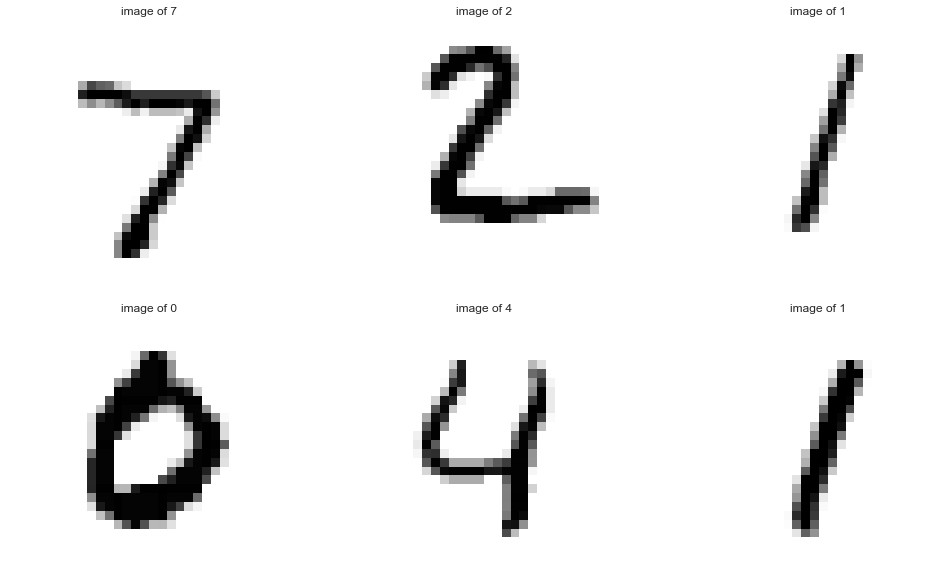

In [4]:
im_data = X_test[:6,:]
im_labels = y_test[:6]

plt.figure(figsize=(17, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.axis('off')
    plt.title("image of {}".format(np.argmax(im_labels[i])))
    plt.imshow(im_data[i].reshape((28, 28)), cmap='binary')
    
plt.show()

In [134]:
tf.reset_default_graph()
np.random.seed(42)

LEARNING_RATE = 1e-3
LOGS_PATH = './ex1_logs'
NUM_EPOCHS = 15

digits = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='Data')
labels = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='Labels')

W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1), dtype=tf.float32, name='Weights')
b = tf.Variable(tf.constant(0.1, shape=[10]), dtype=tf.float32, name='Biases')

with tf.name_scope('Model'):
    pred = tf.matmul(digits, W) + b

with tf.name_scope('Loss'):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=pred)

with tf.name_scope('Train'):
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

with tf.name_scope('Accuracy'):
    equal_labels = tf.equal(tf.argmax(pred, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(equal_labels, dtype=tf.float32))


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(LOGS_PATH, sess.graph)
    sess.run(tf.global_variables_initializer())
    
    for _ in range(NUM_EPOCHS):
        for batch in get_batches(X_train, y_train, size=100):
            train_step.run(feed_dict={digits: batch[0], labels: batch[1]})

    basic_weights = sess.run(W)
  
    print("accuracy on train set", accuracy.eval({digits: X_train,
                                                  labels: y_train}))
    print("accuracy on test set", accuracy.eval({digits: X_test,
                                                 labels: y_test}))

accuracy on train set 0.932633
accuracy on test set 0.9272


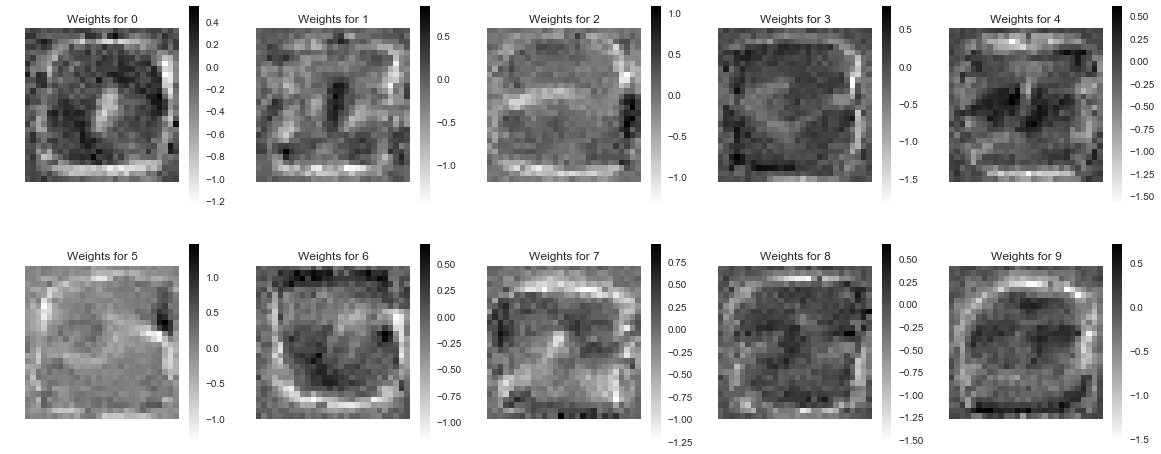

In [135]:
plt.figure(figsize=(20, 8))

for i in range(basic_weights.shape[1]):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title('Weights for {}'.format(i))
    plt.imshow(basic_weights[:,i].reshape((28, 28)), cmap='binary')
    plt.colorbar()
    
plt.show()

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = \sum\limits_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = \sum\limits_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [136]:
tf.reset_default_graph()
np.random.seed(42)

LEARNING_RATE = 1e-3
LOGS_PATH = './ex2_logs'
NUM_EPOCHS = 15

lmd_1 = 5e-4
lmd_2 = 3e-5

digits = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='Data')
labels = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='Labels')

W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1), dtype=tf.float32, name='Weights')
b = tf.Variable(tf.constant(0.1, shape=[10]), dtype=tf.float32, name='Biases')

with tf.name_scope('Model'):
    pred = tf.matmul(digits, W) + b

with tf.name_scope('Loss'):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=pred)
    l1_reg = tf.reduce_sum(tf.abs(W))
    l2_reg = tf.reduce_sum(tf.square(W))
    loss = loss + lmd_1 * l1_reg + lmd_2 * l2_reg

with tf.name_scope('Train'):
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

with tf.name_scope('Accuracy'):
    equal_labels = tf.equal(tf.argmax(pred, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(equal_labels, dtype=tf.float32))


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(LOGS_PATH, sess.graph)
    sess.run(tf.global_variables_initializer())
    
    for _ in range(NUM_EPOCHS):
        for batch in get_batches(X_train, y_train, size=100):
            train_step.run(feed_dict={digits: batch[0], labels: batch[1]})

  
    weights = sess.run(W)
    
    print("accuracy on train set", accuracy.eval({digits: X_train,
                                                  labels: y_train}))
    print("accuracy on test set", accuracy.eval({digits: X_test,
                                                 labels: y_test}))
    


accuracy on train set 0.911467
accuracy on test set 0.9136


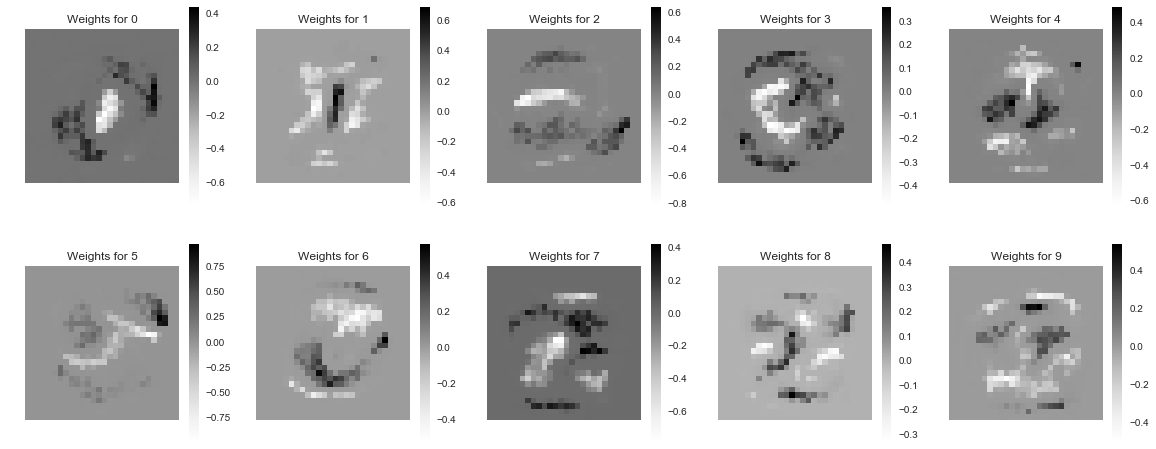

In [137]:
plt.figure(figsize=(20, 8))

for i in range(weights.shape[1]):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title('Weights for {}'.format(i))
    plt.imshow(weights[:,i].reshape((28, 28)), cmap='Greys')
    plt.colorbar()
    
plt.show()

Weights are now more clear to the eye. I think this might be a reason for decreased accuracy: our model with regularizations applied has zero (almost) coefficients in the areas, where digits appear rearly, and has high values of weight for "ordinary" (clear to the eye) countours. This can influence bad predictions for some unusual numbers (like in example pictures after 1 cell). Also there is a big change in the ammount of white noise (l1 influences this).

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). [done]
2. Train 2 layer net. Use sigmoid as nonlinearity. [done]
3. Check accuracy on validation set. [done]
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model. 
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [138]:
def fully_connected_nonlin(inp, units_in, units_out, nonlinearity):
    with tf.name_scope('fully_connected_layer'):
        # initialize weights and biases
        weights = tf.Variable(tf.truncated_normal([units_in, units_out], stddev=0.1), 
                              dtype=tf.float32, name='weights')
        biases = tf.Variable(tf.constant(0.1, shape=[units_out]), dtype=tf.float32, name='biases')
        # find output
        out = nonlinearity(tf.matmul(inp, weights) + biases)
        
        tf.summary.histogram('weights', weights)
        tf.summary.histogram('biases', biases)
        tf.summary.histogram('activations', out)

    return out


def fully_connected_lin(inp, units_in, units_out):
    with tf.name_scope('fully_connected_layer'):
        # initialize weights and biases
        weights = tf.Variable(tf.truncated_normal([units_in, units_out], stddev=0.1), 
                              dtype=tf.float32, name='weights')
        biases = tf.Variable(tf.constant(0.0, shape=[units_out]), dtype=tf.float32, name='biases')
        # find output
        out = tf.matmul(inp, weights) + biases
        
        tf.summary.histogram('weights', weights)
        tf.summary.histogram('biases', biases)
        tf.summary.histogram('activations', out)

    return out

In [139]:
def train_and_eval(
        hidden_layers,
        nonlinearity=tf.nn.relu,
        learning_rate=1e-3,
        learning_rate_decay=False,
        l1_coef=0.0,
        l2_coef=0.0,
        hparams='',
        verbose=True,
        visualize=True):

    # reset everything
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)
    sess = tf.Session()

    digits = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='Data')
    labels = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='Labels')

    if learning_rate_decay:
        lr = tf.placeholder(dtype=tf.float32)
        decay_speed = 1000.0
        min_rate = 1e-4
        max_rate = learning_rate

    # create model based on the parameters
    hidden = fully_connected_nonlin(digits, 784, hidden_layers[0], nonlinearity)
    
    for i in range(len(hidden_layers) - 1):
        hidden = fully_connected_nonlin(hidden, hidden_layers[i], hidden_layers[i + 1], nonlinearity)

    logits = fully_connected_lin(hidden, hidden_layers[-1], 10)
    output = tf.nn.softmax(logits)


    # train network
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        variables = tf.trainable_variables()
        
        if l1_coef != 0.0:
            loss_l1 = tf.add_n([tf.reduce_sum(tf.abs(v)) for v in variables if not 'biases' in v.name])
            loss = loss + l1_coef * loss_l1

        if l2_coef != 0.0:
            loss_l2 = tf.add_n([tf.reduce_sum(tf.square(v)) for v in variables if not 'biases' in v.name])
            loss = loss + l2_coef * loss_l2

        tf.summary.scalar('loss', loss)

    with tf.name_scope('train'):
        if learning_rate_decay:
            step = tf.train.AdamOptimizer(lr).minimize(loss)
        else:
            step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # find accuracy
    with tf.name_scope('accuracy'):
        equal_labels = tf.equal(tf.argmax(labels, axis=1), tf.argmax(output, axis=1))
        accuracy = tf.reduce_mean(tf.cast(equal_labels, dtype=tf.float32))
        
        tf.summary.scalar('accuracy', accuracy)
    
    
    summ = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(LOGS_PATH + hparams)
    summary_writer.add_graph(sess.graph)
    

    # train model
    sess.run(tf.global_variables_initializer())
    iteration = 0
    for i in range(NUM_EPOCHS):
        for batch in get_batches(X_train, y_train, size=100):
            if learning_rate_decay:
                learning_rate = max(max_rate * (0.9**(iteration//decay_speed)), min_rate)
                sess.run(step, {digits: batch[0], labels: batch[1], lr: learning_rate})
            else:
                sess.run(step, {digits: batch[0], labels: batch[1]})

            iteration += 1
            if iteration % 5 and visualize:
                train_accuracy, s = sess.run([accuracy, summ], {digits: batch[0], labels: batch[1]})
                summary_writer.add_summary(s, iteration)

                
        if i % LOGS_PERIOD == 0 and verbose:   
            print("\nEPOCH", i)
            print("-"*30)
            print("LOSS:", sess.run(loss, {digits: X_train, labels: y_train}))
            print("ACCURACY ON TRAIN:", sess.run(accuracy, {digits: X_train, labels: y_train}))
            print("ACCURACY ON TEST: ", sess.run(accuracy, {digits: X_test, labels: y_test}))
    
    print("\nFINISHED TRAINING!")
    print("FINAL ACCURACY ON TRAIN", sess.run(accuracy, {digits: X_train, labels: y_train}))
    print("FINAL ACCURACY ON TEST", sess.run(accuracy, {digits: X_test, labels: y_test}))

### 2 layer networks

In [66]:
LOGS_PATH = 'ex3item24_logs/'
NUM_EPOCHS = 10
LOGS_PERIOD = 3

train_and_eval(
    [500],
    nonlinearity=tf.nn.sigmoid,
    learning_rate=1e-3,
    hparams='sigmoid',
    verbose=False
)

train_and_eval(
    [500],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='relu',
    verbose=False)


FINISHED TRAINING!
FINAL ACCURACY ON TRAIN 0.983048
FINAL ACCURACY ON TEST 0.966571

FINISHED TRAINING!
FINAL ACCURACY ON TRAIN 0.999206
FINAL ACCURACY ON TEST 0.974667


#### Comparison
As it can be seen from the graph, when using relu loss value decreases faster than with sigmoid. This results in better accuracy on train and test sets with relu activation function.

### Adding layers

We already know how network performs with two layers, so let's find out accuracy for 3, 5, 7, 10 layer networks. For generality will use same activation function (relu), same learning rate and same number of epochs.

In [67]:
LOGS_PATH = 'ex3item7_logs/'
NUM_EPOCHS = 8
LOGS_PERIOD = 3

train_and_eval(
    [256, 256],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='3_layers'
)

train_and_eval(
    [256, 256, 256, 256],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='5_layers'
)


train_and_eval(
    [256, 256, 256, 256, 256, 256],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='7_layers'
)


train_and_eval(
    [256, 256, 256, 256, 256, 256, 256, 256, 256],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='10_layers'
)

train_and_eval(
    [256, 256, 128, 128, 64, 32],
    nonlinearity=tf.nn.relu,
    learning_rate=1e-3,
    hparams='7_layers_small'
)


EPOCH 0
------------------------------
LOSS: 0.141982
ACCURACY ON TRAIN: 0.95781
ACCURACY ON TEST:  0.947333

EPOCH 3
------------------------------
LOSS: 0.0357236
ACCURACY ON TRAIN: 0.989556
ACCURACY ON TEST:  0.968667

EPOCH 6
------------------------------
LOSS: 0.0160118
ACCURACY ON TRAIN: 0.995143
ACCURACY ON TEST:  0.970381

FINISHED TRAINING!
FINAL ACCURACY ON TRAIN 0.995651
FINAL ACCURACY ON TEST 0.969619

EPOCH 0
------------------------------
LOSS: 0.156407
ACCURACY ON TRAIN: 0.950032
ACCURACY ON TEST:  0.938952

EPOCH 3
------------------------------
LOSS: 0.0327578
ACCURACY ON TRAIN: 0.990127
ACCURACY ON TEST:  0.969048

EPOCH 6
------------------------------
LOSS: 0.0226777
ACCURACY ON TRAIN: 0.992254
ACCURACY ON TEST:  0.971429

FINISHED TRAINING!
FINAL ACCURACY ON TRAIN 0.992413
FINAL ACCURACY ON TEST 0.969048

EPOCH 0
------------------------------
LOSS: 0.160617
ACCURACY ON TRAIN: 0.947365
ACCURACY ON TEST:  0.933238

EPOCH 3
------------------------------
LOSS: 0.08

#### Comparison

As expected, resulting accuracy decreases with increasy in number of layers. But difference is not very large. But training time differs alot. Therefore, it is better to use less layers and train with more epochs.

### Searching best model

I achieved my highest accuracy using two hidden layers with relu nonlinearity and adam SGD with decaying learning rate. I used decay of learning rate, because without it convergence was less stable, thus often I got 97% accuracy. With decaying learning rate, average accuracy accuracy is higher 98%

In [141]:
LOGS_PATH = 'ex3item6_logs/'
NUM_EPOCHS = 20
LOGS_PERIOD = 3

train_and_eval(
    [500, 200],
    nonlinearity=tf.nn.relu,
    learning_rate=2e-3,
    learning_rate_decay=True,
    hparams='2layers',
    verbose=False,
    visualize=False
)


FINISHED TRAINING!
FINAL ACCURACY ON TRAIN 1.0
FINAL ACCURACY ON TEST 0.9857


### Searching best 8

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.

### Setting up 2 layers autoencoder

After some testing I decided to use relu as nonlinearity, because encoder converged faster and there were less noise in output.

In [52]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(32)

LOGS_PATH = 'ex4item12/'
NUM_EPOCHS = 10
LOGS_PERIOD = 3

digits = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='Data')

weights = {
    'encoder': tf.Variable(tf.truncated_normal([784, 3], stddev=0.1), dtype=tf.float32, name='weights'),
    'decoder': tf.Variable(tf.truncated_normal([3, 784], stddev=0.1), dtype=tf.float32, name='weights')
}

biases = {
    'encoder': tf.Variable(tf.constant(0.1, shape=[3]), dtype=tf.float32, name='biases'),
    'decoder': tf.Variable(tf.constant(0.1, shape=[784]), dtype=tf.float32, name='biases')
}

with tf.name_scope('encoder'):
    encoding = tf.nn.relu(tf.matmul(digits, weights['encoder']) + biases['encoder'])
    
with tf.name_scope('decoder'):
    output = tf.nn.relu(tf.matmul(encoding, weights['decoder']) + biases['decoder'])

target = digits

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(output - target))
    
with tf.name_scope('train'):
    step = tf.train.AdamOptimizer(5e-5).minimize(loss)

In [53]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(NUM_EPOCHS):
    for batch, _ in get_batches(X_train, y_train):
        _, l = sess.run([step, loss], {digits: batch})
    if i % LOGS_PERIOD == 0:
        print("\nEPOCH {} FINISHED".format(i))
        print("LOSS ON BATCH:", l)


EPOCH 0 FINISHED
LOSS ON BATCH: 0.0836997

EPOCH 3 FINISHED
LOSS ON BATCH: 0.0525878

EPOCH 6 FINISHED
LOSS ON BATCH: 0.051181

EPOCH 9 FINISHED
LOSS ON BATCH: 0.0522202


As we can see loss is still big, even encreasing number of epochs doesn't change this. However this kind of result can be expected, while we are using just $3$ features to encode digits. Now let's visualize results of encoder on test digits.

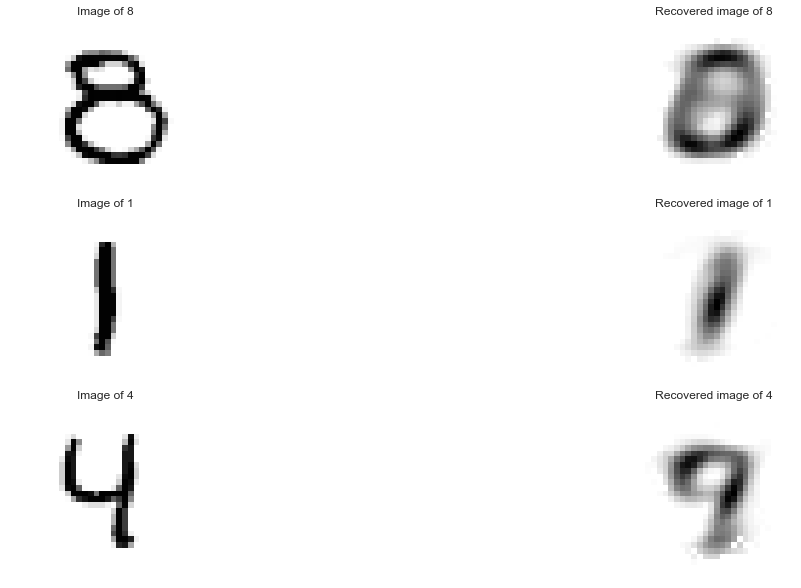

In [55]:
plt.figure(figsize=(20, 10))
np.random.seed(13)
ind = 1
idx = np.random.randint(X_test.shape[0], size=3)
for i in idx:
    inp_image = X_test[i, :]
    rec_image = sess.run(output, {digits: [inp_image]})
    
    plt.subplot(3, 2, ind)
    plt.axis('off')
    plt.title('Image of {}'.format(np.argmax(y_test[i])))
    plt.imshow(inp_image.reshape([28, 28]))

    
    plt.subplot(3, 2, ind + 1)
    plt.axis('off')
    plt.title('Recovered image of {}'.format(np.argmax(y_test[i])))
    plt.imshow(rec_image.reshape([28, 28]))
    
    ind += 2

plt.show()

Now we can visualize encoded vectors for digits.

In [72]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig,show_link = False)